In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

In [3]:
data_dir = Path("data")

In [4]:
holiday_dtype = {
    "type": "category",
    "locale": "category",
    "locale_name": "category",
    "description": "category",
    "transferred": "bool"
}

In [5]:
store_dtype = {
    "store_nbr": "category",
    "family": "category",
    "sales": "float32",
    "onpromotion": "float32"
}

In [6]:
holidays_events = pd.read_csv(
    data_dir / "holidays_events.csv",
    dtype=holiday_dtype,
    parse_dates=["date"]
)

In [7]:
store_sales = pd.read_csv(
    data_dir / "train.csv",
    dtype=store_dtype,
    index_col="date",
    parse_dates=["date"]
)

In [8]:
store_sales = store_sales.to_period("D")

In [9]:
store_sales = store_sales.set_index(["store_nbr", "family"], append=True)

In [10]:
store_sales.drop("id", axis=1, inplace=True)  # Ignore id

In [11]:
average_sales = store_sales.groupby("date")["sales"] \
    .mean() \
    .squeeze()  # Convert to pd.Series

# Plotting helpers

In [12]:
plt.rc("figure", autolayout=True, figsize=(11,7))

In [13]:
import seaborn as sns

# annotations: https://www.kaggle.com/code/ryanholbrook/seasonality
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [14]:
from scipy.signal import periodogram

# annotations: https://www.kaggle.com/code/ryanholbrook/seasonality
def plot_periodogram(ts, detrend='linear', ax=None):    
    fs = pd.Timedelta("2Y") / pd.Timedelta("1D")  # Update to '2Y' so that it includes biannual frequency
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 8, 12, 24, 52, 104, 208])  # Update so that it includes biannual frequency
    ax.set_xticklabels(
        [
            "Biannual (1)",
            "Annual (2)",
            "Semiannual (4)",
            "Quarterly (8)",
            "Bimonthly (12)",
            "Monthly (24)",
            "Biweekly (52)",
            "Weekly (104)",
            "Semiweekly (208)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [15]:
scatter_kws = dict(
    color="0.75",  # Blue color for straight lines
    style=".-",  # Dots connected by lines
    markeredgecolor="0.25",  # Gray dot contour
    markerfacecolor="0.25",  # Gray dots
    legend=False,  # Ignore legend
    alpha=0.7  # Alpha of dots
)

# Seasonal features

## Seasonal indicators

In [16]:
X = average_sales.to_frame()  # Convert pd.Series to pd.DataFrame

In [17]:
X["year"] = X.index.year
X["week"] = X.index.week
X["dayofweek"] = X.index.dayofweek
X["dayofyear"] = X.index.dayofyear
X["weekofyear"] = X.index.weekofyear

<AxesSubplot:title={'center':'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

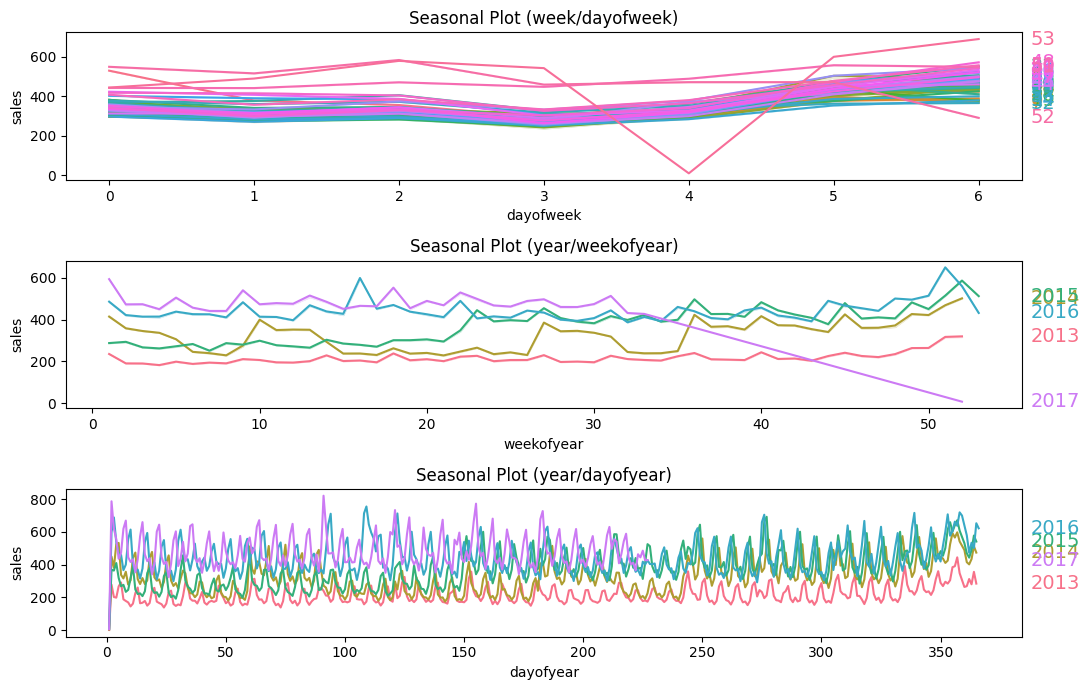

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(11,7))

seasonal_plot(X, y="sales", period="week", freq="dayofweek", ax=ax[0])
seasonal_plot(X, y="sales", period="year", freq="weekofyear", ax=ax[1])
seasonal_plot(X, y="sales", period="year", freq="dayofyear", ax=ax[2])

## Fourier features

C:\Users\carlo\AppData\Local\Temp\ipykernel_15296\1310754901.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales);


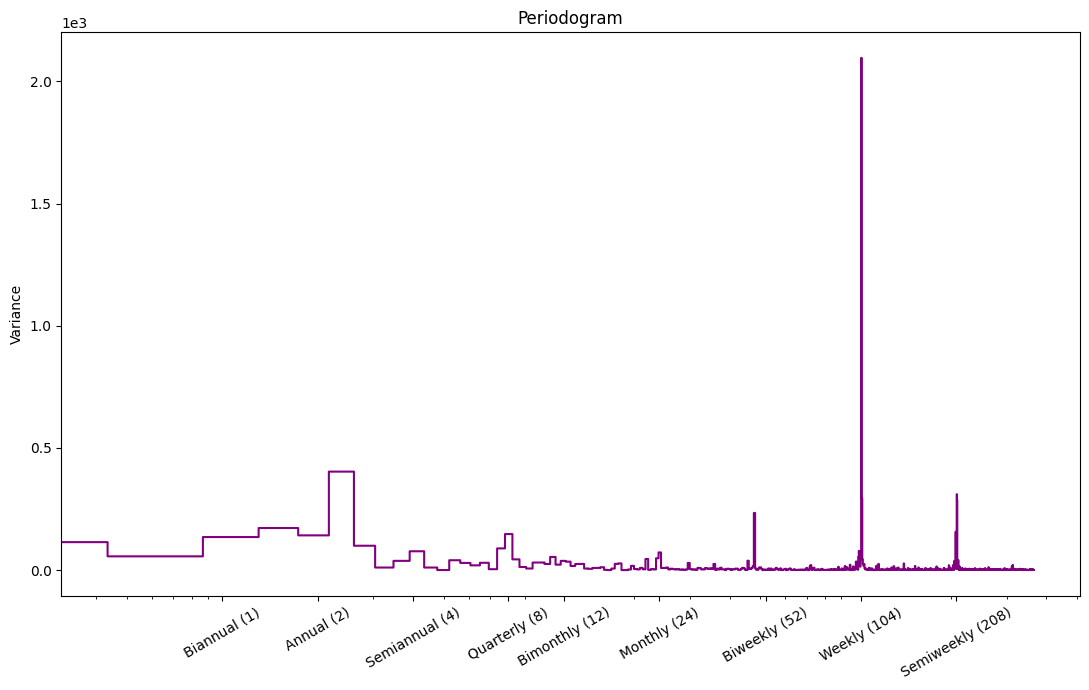

In [19]:
plot_periodogram(average_sales);

From the periodogram it can be seen that the strength of the frequencies starts to decay after quarterly. For this reason, 4 Fourier pairs will be chosen for the model. Regarding the weekly frequency, it will be modelled after a weekly seasonal indicator.

Furthermore, 

In [20]:
y = average_sales.copy()

In [21]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [22]:
fourier0 = CalendarFourier(freq="2Y", order=8)
fourier1 = CalendarFourier(freq="Y", order=4)
fourier2 = CalendarFourier(freq="Y", order=16)

In [23]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier0, fourier1, fourier2],
    drop=True,
)

In [24]:
X = dp.in_sample()

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
model = LinearRegression(fit_intercept=False)

In [27]:
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [28]:
y_pred = pd.Series(
    model.predict(X),
    index=X.index
)

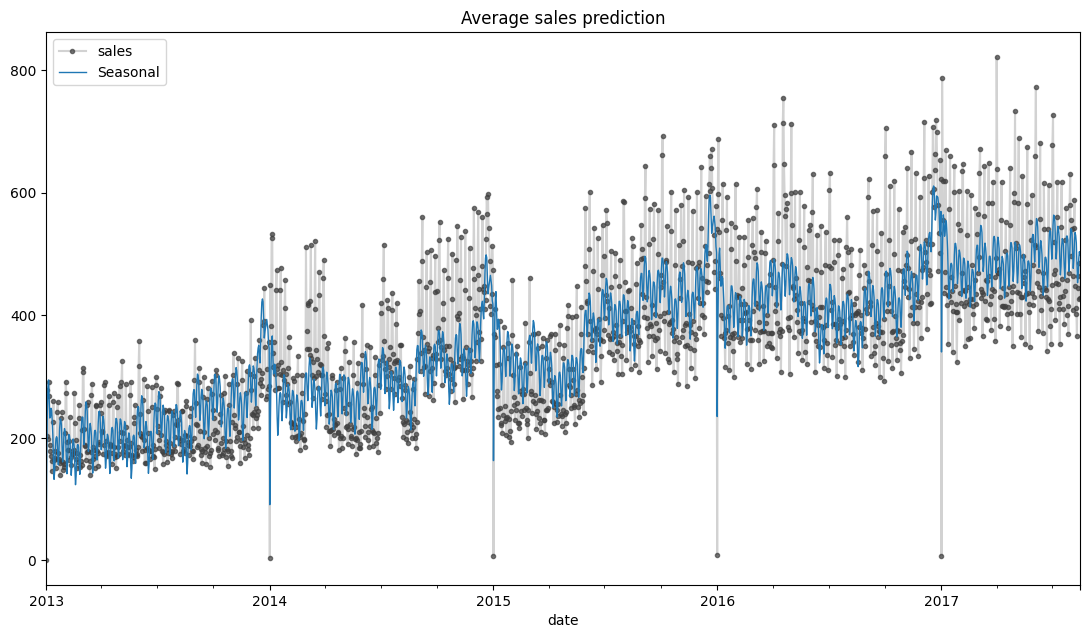

In [29]:
ax = y.plot(**scatter_kws, title="Average sales prediction")
ax = y_pred.plot(ax=ax, label="Seasonal", linewidth=1)

ax.set_aspect("equal")
ax.legend();

In [30]:
y_deseason = y - y_pred

C:\Users\carlo\AppData\Local\Temp\ipykernel_15296\421701625.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax[0] = plot_periodogram(y, ax=ax[0])
C:\Users\carlo\AppData\Local\Temp\ipykernel_15296\421701625.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  ax[1] = plot_periodogram(y_deseason, ax=ax[1])


Text(0.5, 1.0, 'Deseasonalized')

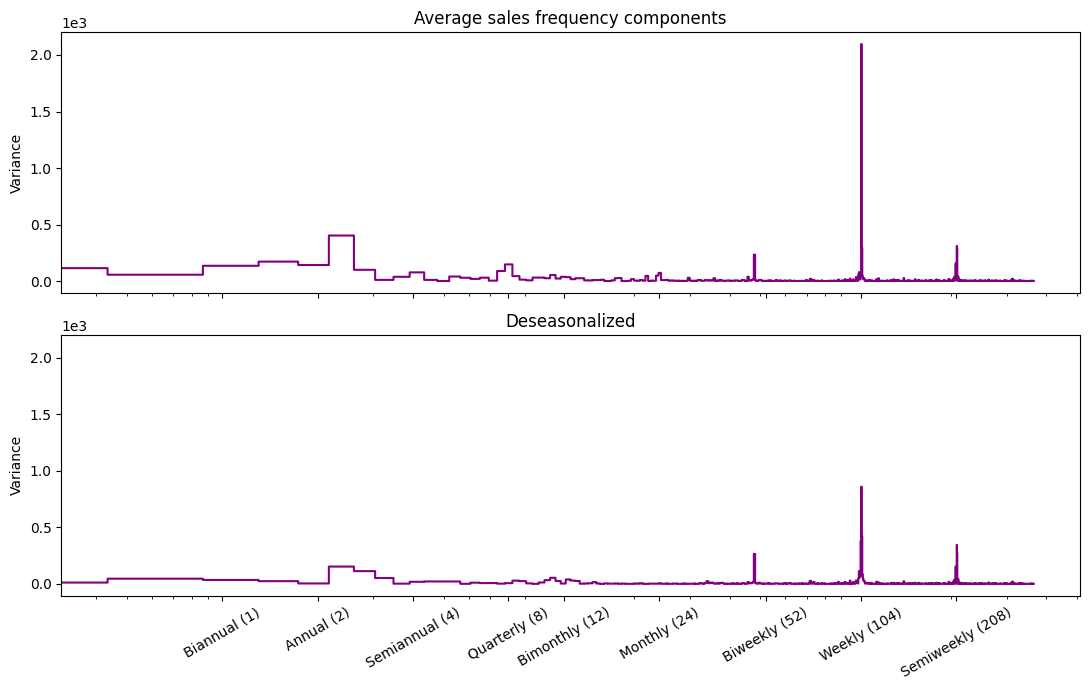

In [31]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(11,7))

ax[0] = plot_periodogram(y, ax=ax[0])
ax[0].set_title("Average sales frequency components")

ax[1] = plot_periodogram(y_deseason, ax=ax[1])
ax[1].set_title("Deseasonalized")